In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import  GradientBoostingClassifier, BaggingClassifier
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

warnings.filterwarnings('ignore')

In [11]:
EPS = 1e-5
FEATURE_SELECTION_PERCENTILE = 85

In [12]:
def custom_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)

def get_confusion_matrix_elements(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return TP, TN, FP, FN

def custom_precision(y_true, y_pred):
    TP, TN, FP, FN = get_confusion_matrix_elements(y_true, y_pred)
    return TP / (TP + FP + EPS)

def custom_recall(y_true, y_pred):
    TP, TN, FP, FN = get_confusion_matrix_elements(y_true, y_pred)
    return TP / (TP + FN + EPS)

def custom_f1(y_true, y_pred):
    p = custom_precision(y_true, y_pred)
    r = custom_recall(y_true, y_pred)
    return 2 * (p * r) / (p + r + EPS)

def print_metrics(y_true, y_pred, name="Model"):
    print(f"{name} Metrics")
    print(f"Accuracy:  Sklearn={accuracy_score(y_true, y_pred):.4f} | Custom={custom_accuracy(y_true, y_pred):.4f}")
    print(f"Precision: Sklearn={precision_score(y_true, y_pred):.4f} | Custom={custom_precision(y_true, y_pred):.4f}")
    print(f"Recall:    Sklearn={recall_score(y_true, y_pred):.4f} | Custom={custom_recall(y_true, y_pred):.4f}")
    print(f"F1 Score:  Sklearn={f1_score(y_true, y_pred):.4f} | Custom={custom_f1(y_true, y_pred):.4f}")

In [13]:
class CustomBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=None, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator if base_estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.rng = np.random.RandomState(random_state)
        
    def fit(self, X, y):
        self.models = []
        X = np.array(X)
        y = np.array(y)
        n_samples = X.shape[0]
        
        for _ in range(self.n_estimators):
            indices = self.rng.choice(n_samples, n_samples, replace=True)
            X_sample, y_sample = X[indices], y[indices]
            
            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self
    
    def predict(self, X):
        X = np.array(X)
        predictions = np.array([model.predict(X) for model in self.models])

        final_preds = []
        for i in range(predictions.shape[1]):
            vals, counts = np.unique(predictions[:, i], return_counts=True)
            final_preds.append(vals[np.argmax(counts)])
        return np.array(final_preds)

In [14]:
class CustomGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.models = []
        self.initial_prediction = None
        
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
        
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        
        pos_frac = np.mean(y)
        self.initial_prediction = np.log(pos_frac / (1 - pos_frac + EPS))
        
        F_val = np.full(y.shape, self.initial_prediction)
        
        for _ in range(self.n_estimators):
            p = self._sigmoid(F_val)
            residuals = y - p
            
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            tree.fit(X, residuals)

            update = tree.predict(X)
            F_val += self.learning_rate * update
            
            self.models.append(tree)
            
        return self
    
    def predict_proba(self, X):
        X = np.array(X)
        F_val = np.full(X.shape[0], self.initial_prediction)
        
        for tree in self.models:
            F_val += self.learning_rate * tree.predict(X)
            
        proba_pos = self._sigmoid(F_val)
        return np.vstack([1 - proba_pos, proba_pos]).T
    
    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)

In [15]:
def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))

def extract_date_parts(df: pd.DataFrame, column: str) -> None:
    if column not in df.columns: return
    parsed = pd.to_datetime(df[column], errors="coerce")
    df[f"{column}_Year"] = parsed.dt.year
    df[f"{column}_Month"] = parsed.dt.month
    df.drop(columns=[column], inplace=True)

def add_bins(df: pd.DataFrame, column: str, bins: list) -> None:
    if column not in df.columns: return
    df[f"{column}Band"] = pd.cut(df[column], bins=bins, labels=False, include_lowest=True).astype(float)

    
def augment_features(df: pd.DataFrame) -> None:
    df.fillna(0, inplace=True)
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPS)

    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPS)
    df["DisposableIncome"] = df["MonthlyIncome"] - total_debt

    df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPS)
    df["LiabilityGap"] = df["TotalLiabilities"] - df["TotalAssets"]
    
    df["SignedLogLiabilityGap"] = signed_log1p(df["LiabilityGap"]) 
    df.drop(columns=["LiabilityGap"], inplace=True)

    df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPS)

    df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (df["NumberOfOpenCreditLines"] + 1)

    df["InquiryPerLine"] =  df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)

    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPS)
    df["LoanDurationYears"] = df["LoanDuration"] / 12.0

    df["CreditHistoryToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + EPS)

    df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
    
    df["AgeAfterExperience"] = df["Age"] - df["Experience"] 

    parsed = pd.to_datetime(df["ApplicationDate"], errors="coerce")
    df["ApplicationDateWeek"] = parsed.dt.isocalendar().week.astype(float)
    df["ApplicationDateDayOfYear"] = parsed.dt.dayofyear
    df["ApplicationDateQuarter"] = parsed.dt.quarter

    add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
    add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])
    add_bins(df, "TotalDebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])
    add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])
    add_bins(df, "Age", [18, 30, 45, 60, np.inf])
    add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])
    add_bins(df, "MonthlyIncome", [0, 2000, 4000, 6000, 8000, 12000, 16000, 25000, np.inf])
    add_bins(df, "CreditCardUtilizationRate", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, np.inf])

In [16]:
class PreprocessingPipeline:
    def __init__(self, scaler_type='zscore'):
        self.scaler_type = scaler_type
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.scaler = StandardScaler() if scaler_type == 'zscore' else MinMaxScaler()
        self.selector = SelectPercentile(score_func=f_classif, percentile=FEATURE_SELECTION_PERCENTILE)
        self.numeric_cols = []
        self.cat_cols = []

    def fit_transform(self, X, y=None):
        X = X.copy()
        
        self.numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
        self.cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()
        if self.numeric_cols:
            X[self.numeric_cols] = self.num_imputer.fit_transform(X[self.numeric_cols])
        
        if self.cat_cols:
            X[self.cat_cols] = self.cat_imputer.fit_transform(X[self.cat_cols])
            X[self.cat_cols] = X[self.cat_cols].astype(str)

        if self.numeric_cols:
            X[self.numeric_cols] = signed_log1p(X[self.numeric_cols])
            X[self.numeric_cols] = self.scaler.fit_transform(X[self.numeric_cols])

        if self.cat_cols:
            self.ohe.fit(X[self.cat_cols])
            cat_encoded = self.ohe.transform(X[self.cat_cols])
            
            cat_feature_names = self.ohe.get_feature_names_out(self.cat_cols)
            cat_df = pd.DataFrame(cat_encoded, columns=cat_feature_names, index=X.index)
            
            X = X.drop(columns=self.cat_cols)
            X = pd.concat([X, cat_df], axis=1)

        if y is not None:
            y = np.array(y).astype(int)
            self.selector.fit(X, y)
            X_sel = self.selector.transform(X)
            return X_sel
            
        return X

    def transform(self, X):
        X = X.copy()
        
        if self.numeric_cols:
            X[self.numeric_cols] = self.num_imputer.transform(X[self.numeric_cols])
        
        if self.cat_cols:
            X[self.cat_cols] = self.cat_imputer.transform(X[self.cat_cols])
            X[self.cat_cols] = X[self.cat_cols].astype(str)

        if self.numeric_cols:
            X[self.numeric_cols] = signed_log1p(X[self.numeric_cols])
            X[self.numeric_cols] = self.scaler.transform(X[self.numeric_cols])

        if self.cat_cols:
            cat_encoded = self.ohe.transform(X[self.cat_cols])
            cat_df = pd.DataFrame(cat_encoded, columns=self.ohe.get_feature_names_out(self.cat_cols), index=X.index)
            X = X.drop(columns=self.cat_cols)
            X = pd.concat([X, cat_df], axis=1)
            
        X_sel = self.selector.transform(X)
        return X_sel

In [17]:
def perform_eda(df, target_column):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target_column, data=df)
    plt.title(f'Distribution of {target_column}')
    plt.show()

    numeric_df = df.select_dtypes(include=np.number)
    corr = numeric_df.corr()
    
    if target_column in corr.columns:
        print("Top correlations with target:")
        print(corr[target_column].sort_values(ascending=False).head(5))
        print(corr[target_column].sort_values(ascending=True).head(5))

        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
        plt.title('Correlation Matrix')
        plt.show()

EDA


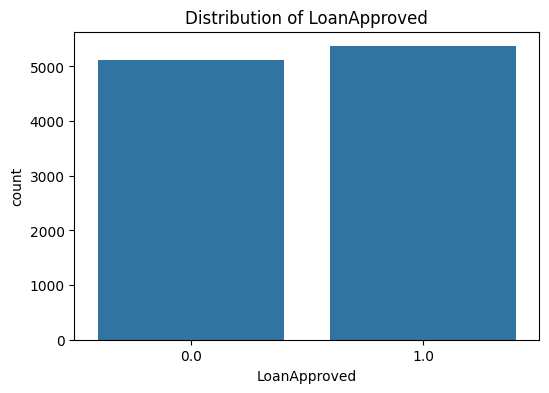

Top correlations with target:
LoanApproved     1.000000
MonthlyIncome    0.754853
AnnualIncome     0.743034
CreditScore      0.581812
NetWorth         0.129624
Name: LoanApproved, dtype: float64
BaseInterestRate         -0.605164
InterestRate             -0.599180
TotalDebtToIncomeRatio   -0.476222
MonthlyLoanPayment       -0.217369
LoanAmount               -0.195607
Name: LoanApproved, dtype: float64


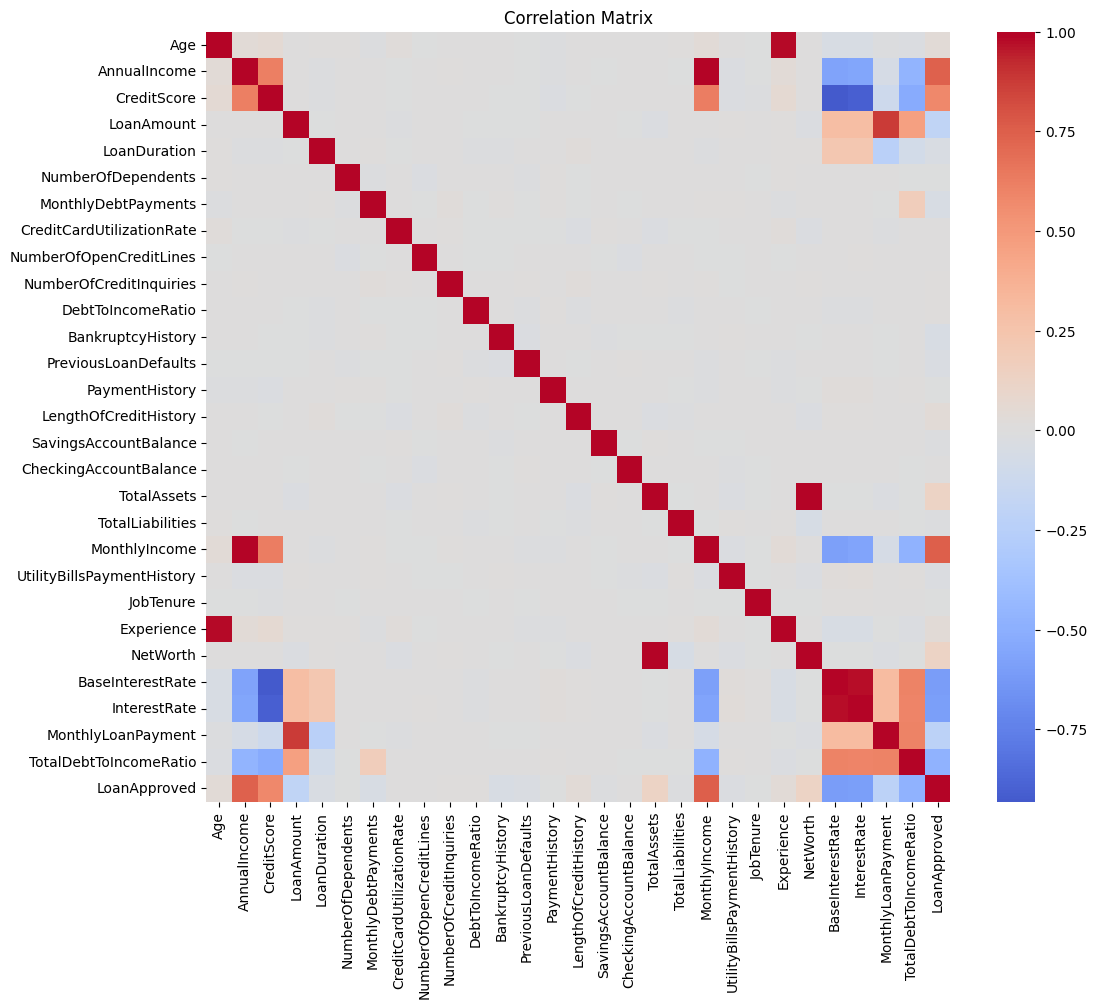

Features after selection: 70

Custom Models Comparison

--- Bagging ---
Custom Bagging Metrics
Accuracy:  Sklearn=0.9211 | Custom=0.9211
Precision: Sklearn=0.9302 | Custom=0.9302
Recall:    Sklearn=0.9060 | Custom=0.9060
F1 Score:  Sklearn=0.9179 | Custom=0.9179
Sklearn Bagging Acc: 0.9183

--- Gradient Boosting ---
Custom GBM Metrics
Accuracy:  Sklearn=0.9115 | Custom=0.9115
Precision: Sklearn=0.9150 | Custom=0.9150
Recall:    Sklearn=0.9022 | Custom=0.9022
F1 Score:  Sklearn=0.9086 | Custom=0.9086
Sklearn GBM Acc: 0.9279

Comparison of Boosting Libraries

Sklearn GBM Accuracy: 0.9342
LightGBM Accuracy: 0.9387
XGBoost Accuracy: 0.9338


[I 2025-12-08 15:05:25,002] A new study created in memory with name: no-name-cade4d8c-a744-4bbe-be92-785405914c31


CatBoost Accuracy: 0.9365

Best Algorithm: LightGBM with Accuracy: 0.9387


[I 2025-12-08 15:05:25,767] Trial 0 finished with value: 0.9355716878402904 and parameters: {'n_estimators': 284, 'max_depth': 11, 'learning_rate': 0.059073622747820895, 'num_leaves': 49}. Best is trial 0 with value: 0.9355716878402904.
[I 2025-12-08 15:05:29,495] Trial 1 finished with value: 0.9342105263157895 and parameters: {'n_estimators': 914, 'max_depth': 15, 'learning_rate': 0.005043986188907994, 'num_leaves': 87}. Best is trial 0 with value: 0.9355716878402904.
[I 2025-12-08 15:05:30,192] Trial 2 finished with value: 0.9351179673321234 and parameters: {'n_estimators': 228, 'max_depth': 12, 'learning_rate': 0.02210144324242139, 'num_leaves': 69}. Best is trial 0 with value: 0.9355716878402904.
[I 2025-12-08 15:05:30,335] Trial 3 finished with value: 0.925589836660617 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.018851903071675297, 'num_leaves': 69}. Best is trial 0 with value: 0.9355716878402904.
[I 2025-12-08 15:05:30,839] Trial 4 finished with value

Best params: {'n_estimators': 362, 'max_depth': 8, 'learning_rate': 0.02689943115048158, 'num_leaves': 77}
ROC-AUC Score: 0.9851
PR-AUC Score: 0.9850

Saved submission to C:/Users/mrshv/Desktop/ML/lab2/submission.csv


In [18]:
output_path = "C:/Users/mrshv/Desktop/ML/lab2/submission.csv"

train_path = "C:/Users/mrshv/Desktop/ML/lab2/dataset/train_c.csv"
test_path = "C:/Users/mrshv/Desktop/ML/lab2/dataset/test_c.csv"


train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

target_column = "LoanApproved"

print("EDA")
perform_eda(train_df, target_column)

augment_features(train_df)
augment_features(test_df)
extract_date_parts(train_df, "ApplicationDate")
extract_date_parts(test_df, "ApplicationDate")

X = train_df.drop(columns=[target_column])
y = train_df[target_column]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor = PreprocessingPipeline()
X_train = preprocessor.fit_transform(X_train_raw, y_train)
X_val = preprocessor.transform(X_val_raw)

print(f"Features after selection: {X_train.shape[1]}")


print("\nCustom Models Comparison")

print("\n--- Bagging ---")
custom_bag = CustomBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)
custom_bag.fit(X_train, y_train)
cb_pred = custom_bag.predict(X_val)
print_metrics(y_val, cb_pred, "Custom Bagging")

sk_bag = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), n_estimators=10, random_state=42)
sk_bag.fit(X_train, y_train)
sb_pred = sk_bag.predict(X_val)
print(f"Sklearn Bagging Acc: {accuracy_score(y_val, sb_pred):.4f}")

print("\n--- Gradient Boosting ---")
custom_gb = CustomGradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
custom_gb.fit(X_train, y_train)
cgb_pred = custom_gb.predict(X_val)
print_metrics(y_val, cgb_pred, "Custom GBM")

sk_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
sk_gb.fit(X_train, y_train)
sgb_pred = sk_gb.predict(X_val)
print(f"Sklearn GBM Acc: {accuracy_score(y_val, sgb_pred):.4f}")

print("\nComparison of Boosting Libraries\n")

models = {
    "Sklearn GBM": GradientBoostingClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1),
    "XGBoost": xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}

best_model_name = ""
best_acc = 0
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")
    if acc > best_acc:
        best_acc = acc
        best_model_name = name

print(f"\nBest Algorithm: {best_model_name} with Accuracy: {best_acc:.4f}")


def objective(trial):
    if best_model_name == "CatBoost":
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True),
            'verbose': 0,
            'random_seed': 42
        }
        model = cb.CatBoostClassifier(**params)
        
    elif best_model_name == "XGBoost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'random_state': 42,
            'n_jobs': -1
        }
        model = xgb.XGBClassifier(**params)
        
    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'random_state': 42,
            'verbose': -1
        }
        model = lgb.LGBMClassifier(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40)

print("Best params:", study.best_params)

X_full_processed = preprocessor.fit_transform(X, y)
X_test_processed = preprocessor.transform(test_df.drop(columns=['ID'], errors='ignore'))

if best_model_name == "CatBoost":
    final_model = cb.CatBoostClassifier(**study.best_params, verbose=0)
elif best_model_name == "XGBoost":
    final_model = xgb.XGBClassifier(**study.best_params)
else:
    final_model = lgb.LGBMClassifier(**study.best_params, verbose=-1)

final_model.fit(X_full_processed, y)

final_model_val = clone(final_model)
final_model_val.fit(X_train, y_train)
y_probs = final_model_val.predict_proba(X_val)[:, 1]

print(f"ROC-AUC Score: {roc_auc_score(y_val, y_probs):.4f}")
print(f"PR-AUC Score: {average_precision_score(y_val, y_probs):.4f}")

test_preds = final_model.predict(X_test_processed)

submission = pd.DataFrame({
    'ID': test_df['ID'] if 'ID' in test_df.columns else range(len(test_preds)),
    'LoanApproved': test_preds
})

submission.to_csv(output_path, index=False)
print(f"\nSaved submission to {output_path}")